In [1]:
##  1. Data Exploration

In [2]:
import sys
print(sys.executable)

C:\Users\Deepak\anaconda3\python.exe


In [3]:
#Importing the necessary librarires

import math
import nltk
import scipy
import string
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [4]:
#Importing the dataset

df = pd.read_csv("IMDB Dataset.csv", header=0)  #'train.tsv'
target = 'sentiment'
df.reset_index(drop=True, inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive



Inference: The Dataset consists of 2 features & 50000 samples.


In [5]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
#Checking the stats of all the columns

display(df.describe())

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [7]:
##  2. Data Preprocessing

In [8]:
#Check for empty elements

print(df.isnull().sum())
print('\n\033[1mInference:\033[0m The dataset doesn\'t have any null elements')

review       0
sentiment    0
dtype: int64

Inference: The dataset doesn't have any null elements


In [9]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-df1.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 418


In [10]:
#Filtering the text

import nltk
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

df = df1.copy()

def preprocessor(text):
    text = text.lower()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text


for i in tqdm(range(df.shape[0])):
    df.loc[i,'review'] = preprocessor(df['review'][i])


df.head()

100%|██████████| 49582/49582 [38:53<00:00, 21.25it/s]  


,review,sentiment
0,one review ha mention watch oz episod youll ho...,positive
1,wonder littl product br br film techniqu veri ...,positive
2,thought thi wa wonder way spend time hot summe...,positive
3,basic famili littl boy jake think zombi hi clo...,negative
4,petter mattei love time money visual stun film...,positive


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
porter=PorterStemmer()
def tokenizer(text):
        return text.split()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
y=df.sentiment.values
x=tfidf.fit_transform(df.review)

In [12]:
##  3. Exploratory Data Analysis (EDA)

            Target Variable Distribution           


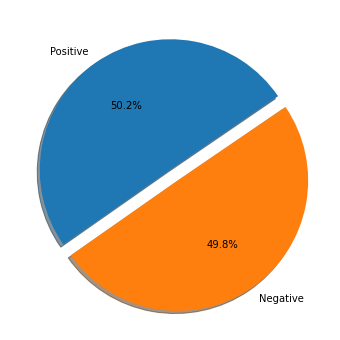

In [13]:
#Let us first analyze the distribution of the target variable

print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df[target].value_counts(), labels=['Positive','Negative'], counterclock=False, shadow=True, 
        explode=[0,0.1], autopct='%1.1f%%', radius=1, startangle=215)
plt.show()

100%|██████████| 49582/49582 [00:03<00:00, 14987.88it/s]


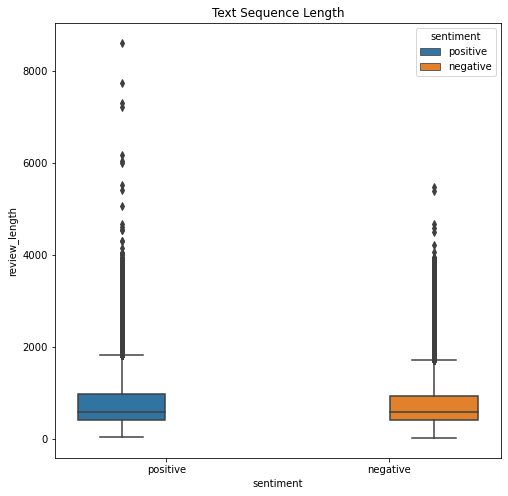

In [14]:
#Visualising the average text sequence length

df2 = df.copy()
df2['review_length'] = 0

for i in tqdm(range(df.shape[0])):
    df2['review_length'][i] = len(df2['review'][i])

plt.figure(figsize=[8,8])
sns.boxplot(x='sentiment',y='review_length', data=df2, hue='sentiment')
plt.title('Text Sequence Length')
plt.show()

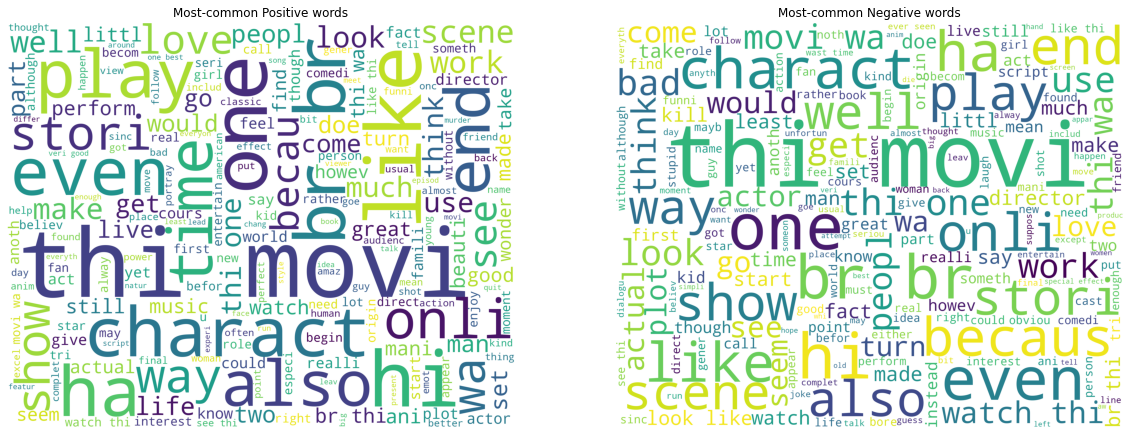

In [15]:
#Visualising the most common positive and negative words

positivedata = df[df['sentiment']== "positive"]
positivedata =positivedata['review']
negdata = df[df['sentiment']== "negative"]
negdata= negdata['review']

def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(positivedata,'white','Most-common Positive words')

plt.subplot(1,2,2)
wordcloud_draw(negdata, 'white','Most-common Negative words')
plt.show()

In [16]:
##  4. Predictive Modeling

In [17]:
#Splitting the data intro training & testing sets

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (49582, 1) (49582,) 
Training set  --->  (39665, 136438) (39665,) 
Testing set   --->  (9917, 136438)  (9917,)


In [18]:
#Let us create first create a table to store the accuracy of the two models 

Evaluation_Results = pd.DataFrame(np.zeros((2,1)), columns=['Accuracy'])
Evaluation_Results.index=['Logistic Regression (LR)','Naïve Bayes Classifier (NB)']
Evaluation_Results

,Accuracy
Logistic Regression (LR),0.0
Naïve Bayes Classifier (NB),0.0


In [19]:
#Let us define functions to summarise the Prediction's scores .

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [20]:
## 1. Logistic Regression:

In [21]:
# Building Logistic Regression Classifier

LR_model = LogisticRegression()
LR = LR_model.fit(Train_X, Train_Y)
pred = LR.predict(Test_X)
pred_prob = LR.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,0)

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 88.8%


In [22]:
## 2. Naive Bayes Classfier:

In [23]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()
NB = NB_model.fit(Train_X, Train_Y)
pred = NB.predict(Test_X)
pred_prob = NB.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,1)

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 84.39999999999999%


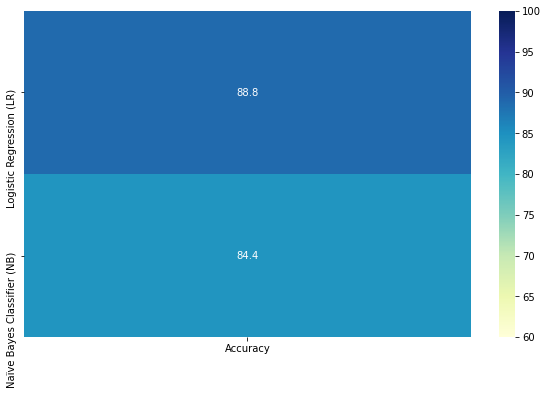

In [24]:
#Comparing both the models Scores

#plt.figure(figsize=[12,5])
sns.heatmap(Evaluation_Results, annot=True, vmin=60, vmax=100.0, cmap='YlGnBu', fmt='.1f')
plt.show()

In [25]:
Evaluation_Results

,Accuracy
Logistic Regression (LR),88.8
Naïve Bayes Classifier (NB),84.4
